In [1]:
from utils.modelUtils import load_sammed2d
from classes.SAMMed2DClass_new import SAMMed2DInferer
from utils.base_classes import Points

import utils.analysisUtils as anUt
import utils.promptUtils as prUt
from utils.imageUtils import read_im_gt

import numpy as np

# Obtain model, image, gt
device = 'cuda'
sammed2d_checkpoint_path = "/home/t722s/Desktop/UniversalModels/TrainedModels/sam-med2d_b.pth"

sammed2d_model = load_sammed2d(sammed2d_checkpoint_path, device)
sammed2d_inferer = SAMMed2DInferer(sammed2d_model)

# img_path = '/home/t722s/Desktop/Datasets/BratsMini/imagesTs/BraTS2021_01646.nii.gz'
# gt_path = '/home/t722s/Desktop/Datasets/BratsMini/labelsTs/BraTS2021_01646.nii.gz'
# img, gt = read_im_gt(img_path, gt_path)

# img_path = '/home/t722s/Desktop/Datasets/amosForUniversegTest/imagesTs/amos_0001.nii.gz'
# gt_path = '/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTs/amos_0001.nii.gz'
# img, gt = read_im_gt_row_major(img_path, gt_path, 2)


img_path = '/home/t722s/Desktop/Datasets/Dataset350_AbdomenAtlasJHU_sub/imagesTr/BDMAP_00000001_0000.nii.gz'
gt_path = '/home/t722s/Desktop/Datasets/Dataset350_AbdomenAtlasJHU_sub/labelsTr/BDMAP_00000001.nii.gz'
img, gt = read_im_gt(img_path, gt_path, 3)


/home/t722s/anaconda3/envs/universalModels/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/t722s/anaconda3/envs/universalModels/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


True
*******load /home/t722s/Desktop/UniversalModels/TrainedModels/sam-med2d_b.pth


In [10]:
# Experiment: 2d bounding box per slice with foreground
box_prompt = prUt.get_minimal_boxes_row_major(gt, 3, 3)
segmentation = sammed2d_inferer.predict(img, box_prompt)
anUt.compute_dice(segmentation, gt)

0.9396739793941389

In [11]:
# Experiment: n randomly sampled points from foreground
seed = 11121
n_clicks = 5
box_prompt = prUt.get_pos_clicks2D_row_major(gt, n_clicks, seed = seed)
segmentation = sammed2d_inferer.predict(img, box_prompt)
anUt.compute_dice(segmentation, gt)

0.9143276197755548

In [12]:
# Experiment: Given n equally spaced slices starting from the lowest axial slice with foreground to the highest, pick a 'central point' and interpolate a curve (DoF: linear vs cubic) between the points
n_clicks = 5
interpolation = 'linear'
simulated_clicks = prUt.get_fg_points_from_cc_centers(gt, n_clicks)
coords = prUt.interpolate_points(simulated_clicks, kind = interpolation).astype(int)
box_prompt = Points({'coords': coords, 'labels': [1]*len(coords)})

segmentation = sammed2d_inferer.predict(img, box_prompt)
anUt.compute_dice(segmentation, gt)

0.912622782583199

In [13]:
# Experiment: get 3d bbox and slice it to feed it in 2d axially
box_prompt = prUt.get_bbox3d_sliced(gt)

segmentation = sammed2d_inferer.predict(img, box_prompt)
anUt.compute_dice(segmentation, gt)

0.7636174284813798

In [14]:
# Experiment: Point propagation

seed = 11121
n_clicks = 5

# Get seed prompt and bounds
seed_point = prUt.get_seed_point(gt, n_clicks)
slices_to_infer = np.where(np.any(gt, axis=(1,2)))[0]

segmentation = prUt.point_propagation(sammed2d_inferer, img, seed_point, slices_to_infer, seed, n_clicks)
print(anUt.compute_dice(gt,segmentation))


Propagating up: 100%|██████████| 22/22 [00:10<00:00,  2.04it/s]


0.7984751851037314


In [2]:
# Experiment: Box propagation

seed_box = prUt.get_seed_box(gt)
slices_to_infer = np.where(np.any(gt, axis=(1,2)))[0]

segmentation = prUt.box_propagation(sammed2d_inferer, img, seed_box, slices_to_infer)

print(anUt.compute_dice(gt,segmentation))

Propagating up: 100%|██████████| 22/22 [00:11<00:00,  1.94it/s]


0.9401329902477384


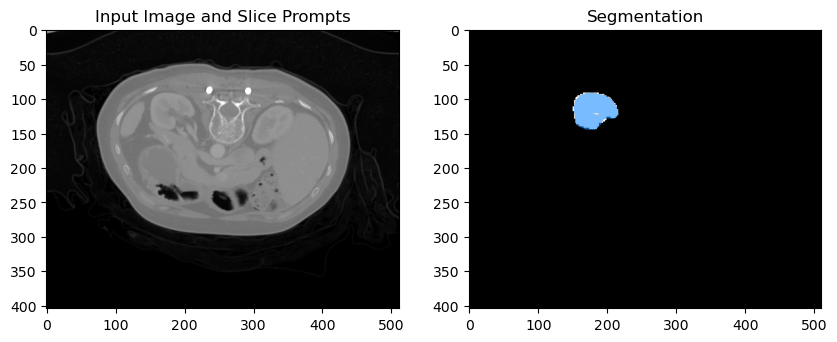

0.953551912568306

In [32]:
# Slice visualisation (points):
slice_idx = 140
anUt.show_seg_row_major(slice_idx+1, img, gt, segmentation) #, pts_prompt= pts_prompt, box_prompt = box_prompt)